# Hyperparameter optimization

In this experiment the hyperparameters of the model will be optimized on cryptocurrency data. The original paper was released with optimized hyperparameters. But because they did not use cryptocurrency data, new experiments will be done for optimizing the model's hyperparameters on cryptocurrency data. This notebook is made to explain the parts of the code of the scripts. For this notebook the experiment on the learning rate is taken as an example.

## Imports

First the necessary modules en scripts are imported.

In [1]:
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys
import math
from preprocess_data import preprocess

WORKDIR_PATH = os.getcwd() + "/../../"
sys.path.insert(1, WORKDIR_PATH)

from base.train_scinet import train_scinet

## Preprocessing

In this part the data is being loaded and preprocessed. At first the settings of the preprocessing are defined.

In [2]:
#data_format = ["timestamp","open","high","low","close","volume",]
data_format = ["price"]
                    
fraction_used = 1
train_frac = 0.6
val_frac = 0.2
test_frac = 0.2

X_LEN = 48
Y_LEN = 24
RANDOM_SEED = 4321#None
OVERLAPPING = True
STANDARDIZE = True

standardization_settings = {'per_sample': True,
                            'leaky': False,
                            'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

Then the dataset is loaded, splitted in samples and train/test sets, and the samples are being normalized.

In [3]:
pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

#df = pd.read_csv(os.path.realpath(__file__) + f"/../data/Data_preprocessed/ETTh1.csv").dropna()
df = pd.read_csv(os.getcwd() + "/data/Binance_BTCUSDT_minute.csv").dropna()
df = df.swapaxes("index", "columns")

data = {} 
for idx, pair in enumerate(pairs):
    data[pair] = df.iloc[idx]
 
results = preprocess(   data = data, 
                        symbols = pairs,
                        data_format = data_format,
                        fraction = fraction_used,
                        train_frac = train_frac,
                        val_frac = val_frac,
                        test_frac = test_frac,
                        X_LEN = X_LEN,
                        Y_LEN = Y_LEN,
                        OVERLAPPING = OVERLAPPING,
                        STANDARDIZE = STANDARDIZE,
                        standardization_settings = standardization_settings
                        )

Starting data preprocessing...
   48740.22  48745.96  48727.47  48727.47.1   2.27206  110730.9135  136.0
0  48763.11  48763.12  48736.70    48736.73   5.33108  259880.1205  427.0
1  48778.58  48778.58  48750.37    48763.12   6.87389  335219.0368  389.0
2  48760.37  48778.58  48746.39    48778.58  10.58951  516291.2896  425.0
3  48799.99  48800.00  48756.93    48760.37  12.24525  597357.8390  535.0
4  48795.99  48800.00  48795.99    48800.00   7.55759  368810.1891  423.0 (49997, 7)
Making train/validation/test splits...
Making samples...


100%|██████████| 29926/29926 [00:13<00:00, 2250.63it/s]
e:\Documenten\GitHub\SCINet-trader\exp\hyperparams\preprocess_data.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)


Making samples...


100%|██████████| 9927/9927 [00:04<00:00, 2366.05it/s]


Making samples...


100%|██████████| 9928/9928 [00:04<00:00, 2416.95it/s]


Making X-y splits...


## Training

Then the model can be trained. At first the hyperparameters which are not being optimized are defined.

In [4]:
EPOCHS = 10
BATCH_SIZE = 8
HID_SIZE = 4
NUM_LEVELS = 3
KERNEL_SIZE = 5
DROPOUT = 0.5
PROBABILISTIC = False

Then some values of the parameter to be tuned (in this case the learning rate) are defined. For each value of this parameter a model is trained and it's performance on the validation set is saved for plotting later on.

In [5]:
LEARNING_RATES = [0.1, 0.01, 0.001, 0.0001]

train_losses = np.zeros((len(LEARNING_RATES), EPOCHS))
val_losses = np.zeros((len(LEARNING_RATES), EPOCHS))
for idx, LEARNING_RATE in enumerate(LEARNING_RATES):

    model, history, X_train , y_train, X_val, y_val, X_test, y_test = train_scinet( X_train = results["X_train"].astype('float32'),
                                                                                    y_train = results["y_train"].astype('float32'),
                                                                                    X_val = results["X_val"].astype('float32'),
                                                                                    y_val = results["y_val"].astype('float32'),
                                                                                    X_test = results["X_test"].astype('float32'),
                                                                                    y_test = results["y_test"].astype('float32'),
                                                                                    epochs = EPOCHS,
                                                                                    batch_size = BATCH_SIZE,
                                                                                    X_LEN = X_LEN,
                                                                                    Y_LEN = [Y_LEN],
                                                                                    output_dim = [results["X_train"].shape[2]],
                                                                                    selected_columns = None,
                                                                                    hid_size= HID_SIZE,
                                                                                    num_levels= NUM_LEVELS,
                                                                                    kernel = KERNEL_SIZE,
                                                                                    dropout = DROPOUT,
                                                                                    loss_weights= [1],
                                                                                    learning_rate = LEARNING_RATE,
                                                                                    probabilistic = PROBABILISTIC)

    train_loss = history.history['loss']
    train_losses[idx] = train_loss

    val_loss = history.history['val_loss']
    val_losses[idx] = val_loss

===========================[SCINET]=====================================
Initializing training with data:
X_train: (29926, 48, 7), y_train: (29926, 24, 7)
X_val: (9927, 48, 7), y_val: (9927, 24, 7)
X_test: (9928, 48, 7), y_test: (9928, 24, 7)
Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 Block_0 (SCINet)            (None, 24, 7)             97332     
                                                                 
Total params: 97,332
Trainable params: 97,332
Non-trainable params: 0
_________________________________________________________________
None
Is null X: 0
Is null y: 0
Epoch 1/10
3741/3741 [==============================] - 132s 30ms/step - loss: 1.4839 - val_loss: 1.5095
Epoch 2/10
3741/3741 [==============================] - 

## Plotting

Here the performance of each model on the validation set is compared using a plot. The hyperparamer of the model with the lowest loss in the validation set can be selected as the optimal value.

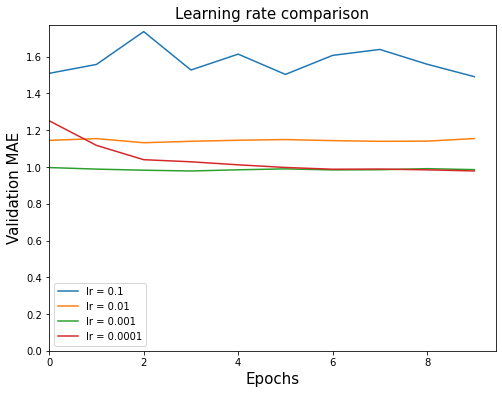

In [6]:
plt.figure(figsize=(8,6))

X = np.arange(EPOCHS)
for idx, lr in enumerate(LEARNING_RATES):
    plt.plot(X, val_losses[idx], label=f'lr = {lr}')

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation MAE', fontsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.title('Learning rate comparison', fontsize=15)
plt.legend()
plt.savefig(f"Optimization_LearningRate.pdf")
plt.show()